# 1. Introduction

This notebook implements the "Q-learning" algorithm for the "Random Walk" environment. The environment is explained in Example 6.2, Section 6.2, in the book "Reinforcement Learning: An Introduction" by Richard S. Sutton and Andrew G. Barto (second edition).

# 2. Python Implementation

## 2.1. Import Packages

In [ ]:
import numpy as np
from gym import Env
from gym.spaces import Discrete
import matplotlib.pyplot as plt
from prettytable import PrettyTable

## 2.2. Create Random Walk Environment

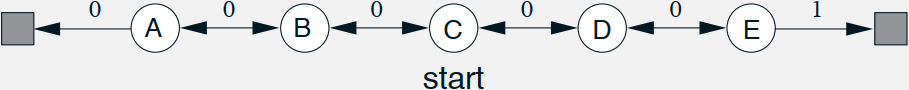

In [ ]:
class RandomWalk(Env):

    def __init__(self):

        self.action_space = Discrete(2)  # 0: go left | 1: go right
        self.observation_space = [i for i in range(7)]  # Terminal <-- A <--> B <--> C <--> D <--> E --> Terminal
        self.initial_state = 3
        self.state = None

    def step(self, action):
        """
        Take action and observe the reward and the next state.

        Actions:
            Num   Action
            0     Go left
            1     Go right

        Rewards:
            +1 when terminating on the extreme right
             0 otherwise
        """

        if action == 0:  # go left
            self.state -= 1
            if self.state == min(self.observation_space):  # left terminal state (extreme left)
                reward = 0
                done = True
            else:
                reward = 0
                done = False

        elif action == 1:  # go right
            self.state += 1
            if self.state == max(self.observation_space):  # right terminal state (extreme right)
                reward = 1
                done = True
            else:
                reward = 0
                done = False

        info = {}

        return self.state, reward, done, info

    def render(self):
        pass

    def reset(self):
        """
        Reset the environment for a new episode.
        """

        self.state = self.initial_state
        return self.state

## 2.3. Q-Learning Algorithm (Q-Learning Agent)

One of the early breakthroughs in reinforcement learning was the development of an off-policy TD control algorithm known as *Q-learning* ([Watkins, 1989](http://www.cs.rhul.ac.uk/~chrisw/thesis.html)), defined by

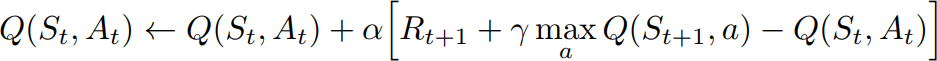

In this case, the learned action-value function, $Q$, directly approximates $q_{*}$, the optimal action-value function, independent of the policy being followed. This dramatically simplifies the analysis of the algorithm and enabled early convergence proofs. The policy still has an effect in that it determines which state-action pairs are visited and updated. However, all that is required for correct convergence is that all pairs continue to be updated. This is a minimal requirement in the sense that any method guaranteed to find optimal behavior in the general case must require it. Under this assumption and a variant of the usual stochastic approximation conditions on the sequence of step-size parameters, $Q$ has been shown to converge with probability $1$ to $q_{*}$.

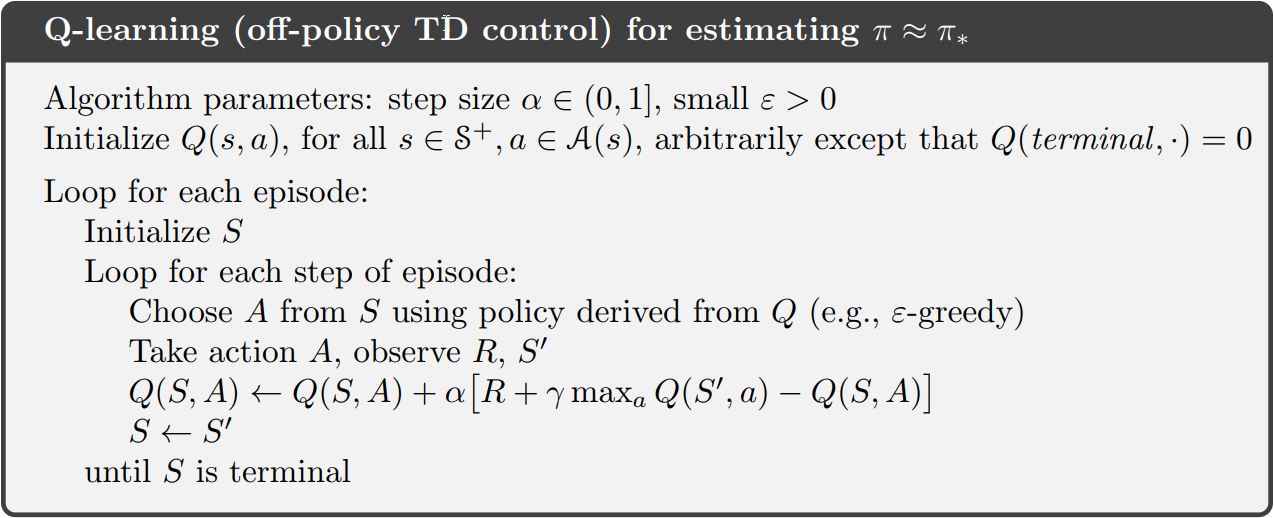

In [ ]:
class Agent:

    def __init__(self, alpha, epsilon, gamma, state_space, action_space, num_actions):

        self.alpha = alpha  # step-size parameter
        self.epsilon = epsilon  # probability of taking a random action in an ε-greedy policy
        self.gamma = gamma  # discount-rate parameter (discount factor)
        self.state_space = state_space
        self.action_space = action_space
        self.num_actions = num_actions

        self.Q = {}
        for s in self.state_space:
            for a in range(self.num_actions):
                self.Q[s, a] = 0

    def policy(self, state):
        """
        Implement the ε-greedy action selection policy.
        """

        q_values = np.array([self.Q[state, a] for a in range(self.num_actions)])
        r = np.random.random()

        if r < self.epsilon:
            action = self.action_space.sample()  # random action - exploration
        else:
            action = np.argmax(q_values)  # greedy action - exploitation

        return action

    def update_values(self, state, action, reward, state_):
        """
        Update the action-value estimates.
        """

        max_q_value = np.max(np.array([self.Q[state_, a] for a in range(self.num_actions)]))
        delta = reward + self.gamma * max_q_value - self.Q[state, action]  # TD error
        self.Q[state, action] += self.alpha * delta

    def decrement_epsilon(self, episodes):
        """
        Decrease the value of ε after each episode.
        **Usage is optional.**
        """

        # This is to decrease the probability of taking a random action and ensure convergence with ε-greedy policies.
        # This is because as the action-value estimates change toward the optimal values, the need for exploration
        # decreases and more exploitation is needed.

        if self.epsilon > 0:
            self.epsilon -= 1 / episodes
        else:
            self.epsilon = 0

## 2.4. Main

### 2.4.1. Helper Function

In [ ]:
def q_table(qt):
    max_row = max(key[0] for key in qt.keys())
    max_col = max(key[1] for key in qt.keys())
    matrix = [[0] * (max_col + 1) for _ in range(max_row + 1)]
    for key, value in agent.Q.items():
        matrix[key[0]][key[1]] = value
    states = ["LT", "A", "B", "C", "D", "E", "RT"]
    table = PrettyTable()
    table.field_names = ["Q(S, A)", "action(0): go left", "action(1): go right"]
    for i, row in enumerate(matrix):
        table.add_row(["state(" + str(i) + "): " + states[i]] + row)
    print(table)

### 2.4.2. Main Code

In [ ]:
env = RandomWalk()
action_space = env.action_space  # Discrete(2) = [0, 1]
num_actions = 2
state_space = env.observation_space

alpha = 0.1  # step-size parameter
epsilon = 1.0  # probability of taking a random action in an ε-greedy policy
gamma = 0.99  # discount-rate parameter (discount factor)

agent = Agent(alpha, epsilon, gamma, state_space, action_space, num_actions)

episodes = 100
total_rewards = []

for episode in range(1, episodes + 1):

    state = env.reset()
    done = False

    total_reward = 0
    steps = 0
    actions = []

    while not done:

        # env.render()
        action = agent.policy(state)
        state_, reward, done, info = env.step(action)
        agent.update_values(state, action, reward, state_)
        state = state_

        total_reward += reward
        steps += 1
        actions.append(action)

    agent.decrement_epsilon(episodes)
    total_rewards.append(total_reward)

    if episode % 1 == 0:
        print(f"======================== Episode: {episode} ========================")
        print(f"Total Reward: {total_reward}")
        print(f"Steps: {steps}")
        print(f"Actions: {actions}")
        q_table(agent.Q)

# env.close()

### 2.4.3. Plot

In [ ]:
x_axis = [i for i in range(1, episodes + 1)]
y_axis = total_rewards

plt.rcParams["font.family"] = "serif"

plt.figure(figsize=(10, 5), dpi=300)

plt.title("Total Reward per Episode", fontsize=12)
plt.xlabel("Episode", fontsize=10)
plt.ylabel("Total Reward", fontsize=10)

plt.plot(x_axis, y_axis, color="green", linewidth=2)
plt.grid()
plt.show()